In [1]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

/Applications/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Applications/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Applications/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <FB753559-B5BA-3279-8C4E-2AB6619F0AE9> /Applications/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# Load the image file
image_path = 'test.jpg'
image = Image.open(image_path)



# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])


# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)

Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


In [3]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)
        
    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """
    
    B, H, W, C = x.shape
    
    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C) 
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    
    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)
    
    return patches

In [4]:
# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)


Total number of windows: 3136


In [6]:
class PatchEmbed(nn.Module):
    """ Convert image to patch embedding
    
    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)
        
        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

In [7]:
# Load the image file
image_path = 'test.jpg'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image) 
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[[ 0.2943,  0.0033,  0.2664,  ..., -0.0393, -0.4098, -0.3320],
         [ 0.2645, -0.0143,  0.2842,  ..., -0.0143, -0.3825, -0.3451],
         [ 0.2477, -0.0058,  0.2645,  ..., -0.0290, -0.3371, -0.3104],
         ...,
         [ 0.4568,  0.0403,  0.4532,  ..., -0.0331, -0.5019, -0.4356],
         [ 0.4716,  0.0341,  0.4585,  ..., -0.0430, -0.4928, -0.4587],
         [ 0.4581,  0.0329,  0.4494,  ..., -0.0436, -0.4924, -0.4490]]],
       grad_fn=<TransposeBackward0>)

In [8]:
print("First patch embedding vector:", patches[0, 0])

First patch embedding vector: tensor([ 0.2943,  0.0033,  0.2664,  0.2179, -0.2241, -0.3701, -0.4657,  0.5152,
        -0.1590, -0.6189, -0.0018, -0.4228, -0.0063, -0.3455,  0.4089, -0.2697,
        -0.6593,  0.0650, -0.2646, -0.4777,  0.6923,  0.3229,  0.0110,  0.0748,
        -0.5280,  0.1065,  0.0076, -0.0776,  0.3900, -0.0110, -0.2525,  0.0534,
        -0.0974, -0.2383,  0.0459,  0.0819, -0.3923, -0.0080, -0.1740,  0.0431,
        -0.1643,  0.3648,  0.1921, -0.1620,  0.2051,  0.0188, -0.0482, -0.2314,
         0.3375, -0.0486, -0.6798, -0.0372, -0.0520, -0.2488,  0.0446,  0.2733,
        -0.1246, -0.2133,  0.0132,  0.0518, -0.1731,  0.0976,  0.1709,  0.2378,
        -0.0953, -0.4357,  0.1226, -0.0400, -0.2264, -0.1897, -0.2981,  0.3109,
        -0.0305, -0.3474,  0.5944,  0.1265,  0.1097,  0.4898,  0.1252,  0.1434,
         0.1114,  0.0771,  0.1198,  0.0259, -0.2019, -0.1616, -0.4504, -0.4854,
        -0.2157,  0.3470,  0.1981,  0.1071, -0.3661, -0.0393, -0.4098, -0.3320],
       gr

In [10]:
from swin_functions_and_classes import *


stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output

torch.Size([1, 3136, 96])


/Applications/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[-0.3065, -0.1973,  0.6993,  ..., -0.4911, -0.9961, -0.8994],
         [-0.3312, -0.2106,  0.7234,  ..., -0.4783, -0.9728, -0.9322],
         [-0.3450, -0.2137,  0.6960,  ..., -0.4846, -0.9061, -0.8920],
         ...,
         [-0.0205,  0.0914,  1.0008,  ..., -0.4855, -1.1964, -0.9407],
         [-0.0200,  0.0867,  1.0151,  ..., -0.4915, -1.1953, -0.9651],
         [-0.0290,  0.0770,  1.0033,  ..., -0.4950, -1.1874, -0.9600]]],
       grad_fn=<AddBackward0>)

In [11]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [12]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


In [13]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[ 0.4196,  0.3875,  0.7509,  ...,  0.2268, -0.0988, -0.1362],
         [ 0.3861,  0.3409,  0.7852,  ...,  0.2440, -0.0867, -0.1874],
         [ 0.3763,  0.3516,  0.7630,  ...,  0.2381, -0.0375, -0.1291],
         ...,
         [ 0.5403,  0.3633,  0.9259,  ...,  0.1660, -0.2167, -0.2682],
         [ 0.5547,  0.3478,  0.9355,  ...,  0.1610, -0.2009, -0.2927],
         [ 0.5398,  0.3468,  0.9296,  ...,  0.1591, -0.2053, -0.2787]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.2249, -0.3114,  0.4363,  ..., -0.2402, -0.8159,  0.0929],
         [ 0.2008, -0.3262,  0.4518,  ..., -0.2096, -0.8107,  0.0728],
         [ 0.1926, -0.3528,  0.4432,  ..., -0.1500, -0.8080,  0.0714],
         ...,
         [ 0.3992, -0.2083,  0.5187,  ..., -0.2083, -0.9809, -0.0489],
         [ 0.4198, -0.2213,  0.5225,  ..., -0.2132, -0.9667, -0.0731],
         [ 0.4049, -0.2248,  0.5175,  ..., -0.2131, -0.9669, -0.0598]]],
       grad_fn=<AddBackward0>)


In [14]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

In [60]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
train_dir = os.path.join(current_directory, "custom_dataset", "train")
test_dir = os.path.join(current_directory, "custom_dataset", "test")
print(train_dir)
print(test_dir)

/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/custom_dataset/train
/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/custom_dataset/test


In [61]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


In [62]:
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [63]:
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fca70ae5670>,
 ['Grape Black rot',
  'Grape Esca Black Measles',
  'Grape Leaf blight Isariopsis Leaf Spot',
  'Grape healthy'])

/Applications/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Applications/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Applications/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <FB753559-B5BA-3279-8C4E-2AB6619F0AE9> /Applications/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Applications/anaconda3/lib/python3.9/site-pa

torch.Size([3, 224, 224]) tensor(0)


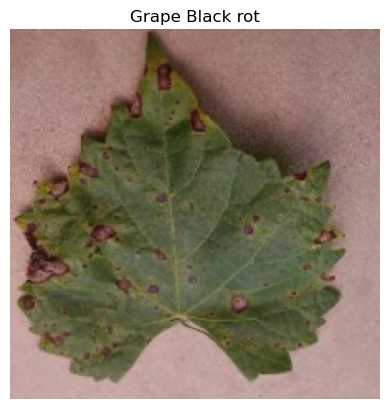

In [66]:
# Let's visualize an image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [67]:
model = SwinTransformer(num_classes=len(class_names))

In [70]:
from going_modular.going_modular import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device



'cpu'

In [71]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

In [72]:
# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=1,
                       device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

/Applications/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Applications/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Applications/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <FB753559-B5BA-3279-8C4E-2AB6619F0AE9> /Applications/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Applications/anaconda3/lib/python3.9/site-pa

KeyboardInterrupt: 

In [ ]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [ ]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)